# Women's presence on Wikipedia: A comprehensive analysis on the evolution of women's recognition over time, country and ethnicity.

## Abstract
In the recent century, in a lot of countries, women have finally gained more rights and we have been continuously progressing towards a more equal society. Our goal in this project is to try to highlight the evolution of social gender inequalities in different domains through the ages. Our interest is on the achievements and recognition of the work done by women in different fields as far back as the data goes. We will use the data from Wikipedia and gather data on number of women referenced, their contribution to their domain, and other parameters and compare it with the same data for men. We will also try to find how the country of origin and the time of acquisition of the rights has an significant impact.

## Research questions
Can we accurately use wikipedia database to show the gender inequalities through time?

Are there any evidence that the men/women equality is reached?

What are the domains in which there is more/less equality? Does this change according to regions/country/language?

What is the effect of women empowering events: Right to work, Sufragettes, War effort, ...?

Since some countries have delayed women's rights, is the evolution similar, in term of timeframe, extent?

## Datasets
For this project, we used the [wikidata](https://dumps.wikimedia.org/wikidatawiki/entities/) dataset which repertoriates the data from every Wikipedia article. It is stored in the form of a JSON data dump where the top level structure is organised as folows:
 - id
 - type
 - labels
 - descriptions
 - aliases
 - claims
 - sitelinks
 - lastrevid
 - modified
 
Here we are only interested in keeping some of the properties for every article, mainly the `instance of`, `sex or gender`, `field of work`, `country of origin` and `date of birth`. From this we will make our analysis and conclude.
 
 
To have an easier time visualizing the data at first, we used the [WHGI](http://whgi.wmflabs.org/). This is based on the wikidata JSON file and updated weekly. This data is stored in the form of a `.csv` and contains information about the ethnicity, field of work and times of death/birth divided into different genders. For our analysis, we are only interested in comparing data for the two most frequent genders: male and female.
 
As an extra comparaison tool, we also used the [UN population data](https://population.un.org/wpp/Download/Standard/Population/) that stores a lot of info about the population of each country in gender and age groups. This data only goes back to 1960 but can still be usefull for recentcomparaison.


## Code

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import datetime
import re
import os
import matplotlib.pyplot as plt
import time 
import math

import findspark
findspark.init()

from pyspark.sql import *
import pyspark.sql.functions as F

from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

**The Data:** We have chosen to go with the original Wikidata json file, after some parsing and data ckeaning, we have obtained a file that contained all the raw information we wanted in a more exhaustive fashion than the data from WHGI.

In [7]:
DATA_PATH = "data/"
# Loading all the (raw) human data from wikidata
humans_df = spark.read.json(os.path.join(DATA_PATH, "humans_strip2.json"))

Usefull functions for initial treatment of the data

In [8]:
def to_datetime(date, how='months'):
    """
    Converts the string date to an integer containing the date info. Can return multiple types of 
    elapsed time measurments.
    
    IN: 'date' str with the date info, 'how' keyword argument to specify the return type
    
    OUT: integer value for the date
    """
    if date != None:
        if date[0] != '-':
            if how == 'months':
                try:
                    # Aproximate elapsed months count since 1 AD
                    return math.floor(( datetime.datetime.strptime(date[1:-1], '%Y-%m-%dT%H:%M:%S') 
                                - datetime.datetime(1, 1, 1) ).days/30)
                except :
                    return None
            elif how == 'years':
                try:
                    # Years 
                    return int(date[1:5])
                except :
                    return None    
            elif how == 'days':
                try:
                    # Elapsed days since 1 AD
                    return math.floor(( datetime.datetime.strptime(date[1:-1], '%Y-%m-%dT%H:%M:%S') 
                                - datetime.datetime(1, 1, 1) ).days)
                except :
                    return None
    return None


def get_gender(gender):
    """
    Returns the gender from the Wikidata ids labels
    """
    if gender == 'Q6581097':
        return 'male'
    elif gender == 'Q6581072':
        return 'female'
    else:
        return None

In [15]:
def clean_dates(df):
    """
    Removes erroneous dates in the data
    """
    err_dates = [1901, 1947, 1949, 1950, 1953, 2000]
    return df[~df['BirthYear'].isin(err_dates)]

def normalize_count(df):
    """
    Outputs normalized counts of article per year, used to compare the curve's shapes
    """
    return df['count'].apply(lambda r: r/df['count'].max())

In [9]:
# Date/gender extraction and schema specification
humans = spark.createDataFrame(humans_df.rdd.map(lambda r: Row(Id=r[0], 
                                                               BirthYear=to_datetime(r[1], how='years'),
                                                               BirthMonth=to_datetime(r[1]),
                                                               BirthDay=to_datetime(r[1], how='days'),
                                                               BirthPlace=r[2],
                                                               Citizenships=r[3],
                                                               Death=to_datetime(r[4]),
                                                               Gender=get_gender(r[5]),
                                                               Name=r[6],
                                                               Occupations=r[7],
                                                               Sitelinks=r[8]))
                              ).filter("BirthMonth is not null and Gender is not null")

humans.printSchema()
humans.show(3)

root
 |-- BirthDay: long (nullable = true)
 |-- BirthMonth: long (nullable = true)
 |-- BirthPlace: string (nullable = true)
 |-- BirthYear: long (nullable = true)
 |-- Citizenships: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Death: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Occupations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Sitelinks: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------+----------+----------+---------+--------------+-----+------+-----+-----------------+--------------------+--------------------+
|BirthDay|BirthMonth|BirthPlace|BirthYear|  Citizenships|Death|Gender|   Id|             Name|         Occupations|           Sitelinks|
+--------+----------+----------+---------+--------------+-----+------+-----+-----------------+--------------------+--------------------+
|  632286|  

## Quick visualization of the data
We rapidly extract the data and show the evolution of the number of articles for both gender through time. The choice was made to only study the evolution since 1700 since before that, the nuber of articles is very sparse and the representation of women was not something of importance.

In [10]:
# Seperation of the data on gender 
men = humans.filter("Gender == 'male'")
women = humans.filter("Gender == 'female'")

In [18]:
# Export to Pandas for plotting
men_pd_yr =  men.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                .toPandas().sort_values(by='BirthYear')

women_pd_yr = women.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                   .toPandas().sort_values(by='BirthYear')

Evolution of number of Wikipedia articles in function of birth year

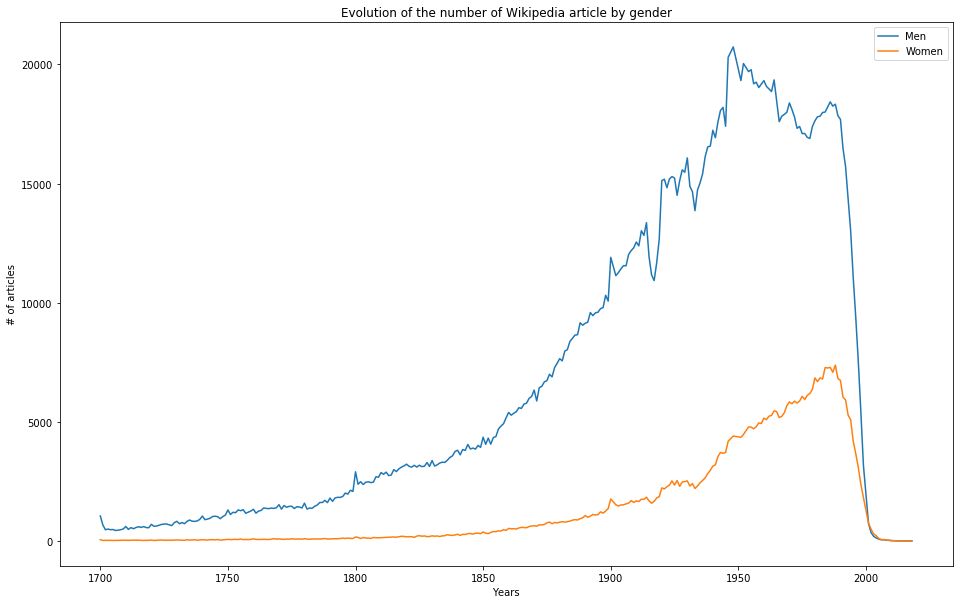

In [25]:
# Removes date with erroneous values
df_women_yr = clean_dates(women_pd_yr)
df_men_yr = clean_dates(men_pd_yr)

plt.figure(figsize=(16, 10))
plt.plot(df_men_yr[(df_men_yr['BirthYear'] >= 1700) & (df_men_yr['BirthYear'] <= 2018)]['BirthYear'], 
         df_men_yr[(df_men_yr['BirthYear'] >= 1700) & (df_men_yr['BirthYear'] <= 2018)]['count'])
plt.plot(df_women_yr[(df_women_yr['BirthYear'] >= 1700) & (df_women_yr['BirthYear'] <= 2018)]['BirthYear'], 
         df_women_yr[(df_women_yr['BirthYear'] >= 1700) & (df_women_yr['BirthYear'] <= 2018)]['count'])

plt.title('Evolution of the number of Wikipedia article by gender')
plt.xlabel('Years'); plt.ylabel('# of articles')
plt.legend(['Men', 'Women']);

**TODO? compare to the data from WHGI to see if that the curves are similar**

**Analysis:**
From this figure, we can see that the number of articles for women on Wikipedia is lower than the number for men.

## Effects of the ethnicity:
Here, we use the nationality of the people listed on wikipedia to extract for each country (the 2OO most populated ones). With this info, we have regrouped arbitrarly the nationalities into regions of similar cultures or ethnicity to have bigger and more significative data.

In [20]:
def get_humans_w_cit(df, cit_list):
    """
    Find the human for a given list of citizenships, separeted by gender
    
    IN: Dataframe of every people and list of citizenships to group them by
    
    OUT: Pandas dataframes for men and women of given ctizenships
    """
    
    citizens = df.select("Id", "BirthYear", "Citizenships", "Gender") \
                 .withColumn("Citizenships", F.explode("Citizenships")) \
                 .filter(F.col("Citizenships").isin(cit_list))
    
    men = citizens.filter("Gender == 'male'")
    women = citizens.filter("Gender == 'female'")
    
    men_pd_yr =  men.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                .toPandas()
    men_pd_yr = men_pd_yr[(men_pd_yr['BirthYear'] >= 1700) & (men_pd_yr['BirthYear'] <= 2018)]
    
    women_pd_yr = women.select('Id', 'BirthYear').groupBy("BirthYear").count() \
                       .toPandas()
    women_pd_yr = women_pd_yr[(women_pd_yr['BirthYear'] >= 1700) & (women_pd_yr['BirthYear'] <= 2018)]
    
    return men_pd_yr.sort_values(by='BirthYear'), women_pd_yr.sort_values(by='BirthYear')


In [26]:
# Creates a dictionary separating regions of the gobe by using the IDs of the 200 most frequent citizenships
regions = {"NA":['Q30', 'Q16'],
           "W_EU":['Q145', 'Q174193', 'Q21', 'Q142', 'Q29', 'Q38', 'Q183', 'Q7318', 'Q16957', 'Q713750', 'Q39'],
           "E_EU":[],
           "NE_AS":['Q17', 'Q8646', 'Q865', 'Q884'],
           "SE_AS":['Q869', 'Q928', 'Q424', 'Q252', 'Q819', 'Q881', 'Q833', 'Q836', 'Q334'],
           "M_AS":['Q668', 'Q837', 'Q902', 'Q854', 'Q843'],
           "MA":['Q1028', 'Q79', 'Q948', 'Q1016', 'Q262'],
           "SA":[],
           "ME":['Q851', 'Q878', 'Q219060', 'Q846', 'Q801', 'Q822', 'Q889', 'Q796', 'Q810', 'Q794', 
                 'Q858', 'Q817', 'Q398'],
           "CN":['Q29520', 'Q13426199', 'Q148']
         }

In [35]:
def display_coutries(keys):
    """
    Displays the countries in each region from the dict keys
    """
    # Loading of the dict from the file
    dict_cit = {}
    with open(os.path.join("dict", "citizenships_dict.json"), mode='rt') as f:
        for line in f:
            dict_cit.update(eval(line.rstrip('\n')))
    for key in keys:
        print("{} :".format(key))
        for citiz_id in regions[key]:
            print("\t-", dict_cit[citiz_id])

### Evolution of article count in similar cultures
Here we compare the evolution between Western Europe and North America

In [30]:
NA_m, NA_w = get_humans_w_cit(humans, regions['NA'])
EU_m, EU_w = get_humans_w_cit(humans, regions['W_EU'])

In [38]:
display_coutries(['NA', 'W_EU'])

NA :
	- United States of America
	- Canada
W_EU :
	- United Kingdom
	- United Kingdom of Great Britain and Ireland
	- England
	- France
	- Spain
	- Italy
	- Germany
	- Nazi Germany
	- German Democratic Republic
	- West Germany
	- Switzerland


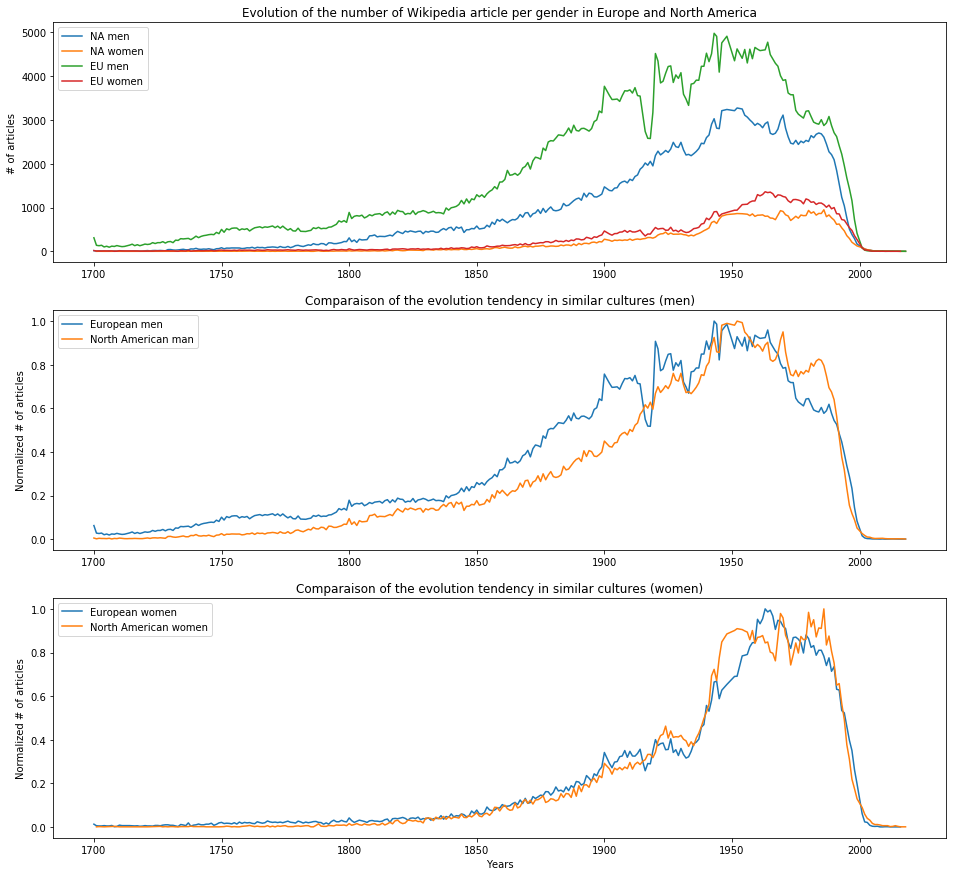

In [57]:
plt.figure(figsize=(16, 15))

plt.subplot(311)
plt.plot(clean_date(NA_m)['BirthYear'], (clean_date(NA_m)['count']),
         clean_date(NA_w)['BirthYear'], (clean_date(NA_w)['count']))

plt.plot(clean_date(EU_m)['BirthYear'], (clean_date(EU_m)['count']),
         clean_date(EU_w)['BirthYear'], (clean_date(EU_w)['count']))

plt.legend(['NA men', 'NA women', 'EU men', 'EU women'], loc=2)
plt.title('Evolution of the number of Wikipedia article per gender in Europe and North America')
plt.ylabel('# of articles')

plt.subplot(312)
plt.plot(clean_date(EU_m)['BirthYear'], normalize_count(clean_date(EU_m)),
         clean_date(NA_m)['BirthYear'], normalize_count(clean_date(NA_m)))
plt.legend(['European men', 'North American man'], loc=2)
plt.title('Comparaison of the evolution tendency in similar cultures (men)')
plt.ylabel('Normalized # of articles');

plt.subplot(313)
plt.plot(clean_date(EU_w)['BirthYear'], normalize_count(clean_date(EU_w)),
         clean_date(NA_w)['BirthYear'], normalize_count(clean_date(NA_w)))
plt.legend(['European women', 'North American women'], loc=2)
plt.title('Comparaison of the evolution tendency in similar cultures (women)')
plt.xlabel('Years'); plt.ylabel('Normalized # of articles');

The data here shows the evolution of genders on Wikipedia in Western Europe and North America. The evolution for both regions is very similar due to the cultural developement date similarities. Even though the nuber of articles can lack straight number similarities, when normalized we can see that the evolution curve is the same.


We can also see that that the number of Wikipedia articles is a good indicator of the total population in each region. In the European trace, we can see significant dips in population during both wars. Whereas, the american poplation is mostly unnafected by WW1.

Therefore, we conclude that cultural similarities lead to similarities in gender representaion

### Evolution for different cultures
Now we try and compare the evolution across cultures. The comparaison was made between North East Asia and muslim countries, in two sets, Magrheb and the Middle-East

In [58]:
NE_AS_m, NE_AS_w = get_humans_w_cit(humans, regions['NE_AS'])
ME_m, ME_w = get_humans_w_cit(humans, regions['ME'])
MA_m, MA_w = get_humans_w_cit(humans, regions['MA'])

In [68]:
display_coutries(['NE_AS'])

NE_AS :
	- Japan
	- Hong Kong
	- Taiwan
	- South Korea


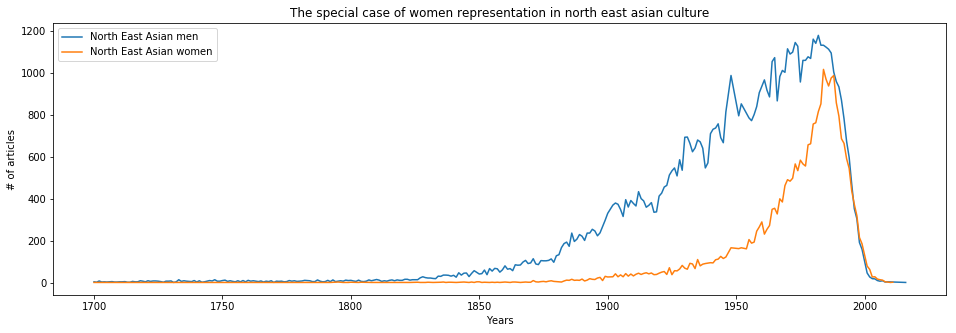

In [69]:
plt.figure(figsize=(16, 5))
plt.plot(clean_date(NE_AS_m)['BirthYear'], (clean_date(NE_AS_m)['count']),
         clean_date(NE_AS_w)['BirthYear'], (clean_date(NE_AS_w)['count']))
plt.legend(['North East Asian men', 'North East Asian women'])
plt.title('The special case of women representation in north east asian culture')
plt.xlabel('Years'); plt.ylabel('# of articles');

For this culture group (highly developped asian countries) we can see that although, similarly to all the other cultures, women weren't represented at first. The number of articles about them has grown at a huge rate later and has almost reached an equality point.

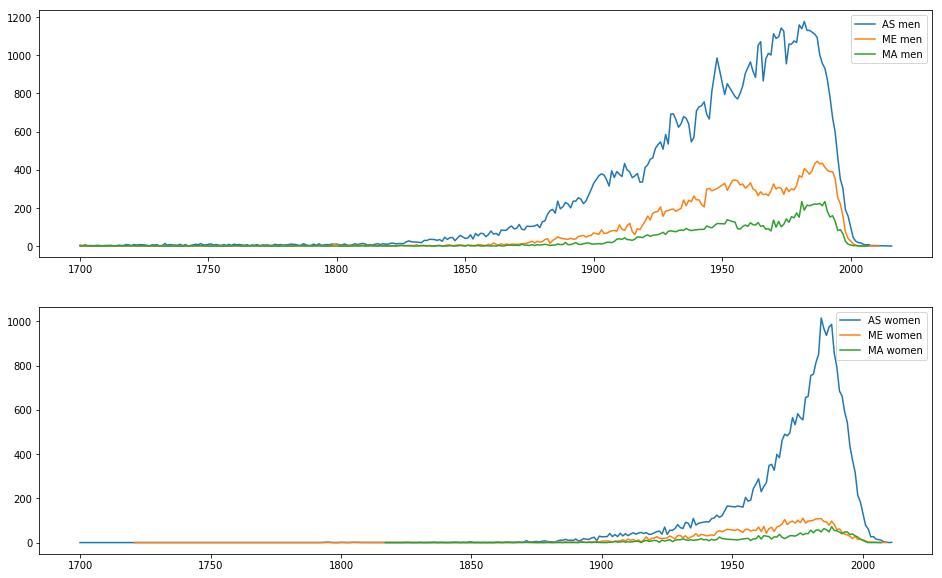

In [61]:
plt.figure(figsize=(16, 10))
plt.subplot(211)
plt.plot(clean_date(NE_AS_m)['BirthYear'], (clean_date(NE_AS_m)['count']),
         clean_date(ME_m)['BirthYear'], (clean_date(ME_m)['count']),
         clean_date(MA_m)['BirthYear'], (clean_date(MA_m)['count']))
plt.legend(['AS men', 'ME men', 'MA men'])
plt.subplot(212)
plt.plot(clean_date(NE_AS_w)['BirthYear'], (clean_date(NE_AS_w)['count']),
         clean_date(ME_w)['BirthYear'], (clean_date(ME_w)['count']),
         clean_date(MA_w)['BirthYear'], (clean_date(MA_w)['count']))
plt.legend(['AS women', 'ME women', 'MA women'])